In [11]:
from Population import Population
from Simulation import Simulation
from GeneticFunctions import sawtooth, descendingSawtooth, exponentialDecay

In [2]:
import numpy as np
import random
import matplotlib.pyplot as plt
from scipy import signal
from IPython.display import clear_output
import time
import cv2
import os

In [3]:
def calc_fitness(agent, points):
    return -np.sum(np.sum((points[agent[:-1]] - points[agent[1:]]) ** 2, axis=1) ** 0.5)

In [4]:
def mutate_agent(agent, rate, bounds=None):
        if rate < 1/1000000:
            return agent.astype(int)
    
        mutations = np.random.uniform(0,1/rate, size=agent.shape)
        mutations[mutations>1] = 0
        temp = agent[mutations!=0]
        np.random.shuffle(temp)
        agent[mutations!=0] = temp

        return agent.astype(int)

def plot_agents(pop):
    fig, ax = plt.subplots(1,1,figsize=(8,8))
    for agent in pop.agents:
        ax.plot(pop.points[:,0][agent], pop.points[:,1][agent], alpha=0.1)
    return fig

def baseline_path(points):
    paths = []
    for ind, point in enumerate(points):
        visited = np.zeros(shape=(points.shape[0]))
        visited[ind] = 1
        path = []
        path.append(ind)
        currInd = ind
        for i in range(len(points[visited==0])):
            nearestPoint = points[visited==0][np.argmin([np.linalg.norm(points[currInd] - x) for x in points[visited==0]])]
            currInd = np.where(points == nearestPoint)[0]
            path.append(currInd[0])
            visited[currInd] = 1

        paths.append(np.array(path))
    return paths[np.argmin([(-1 * calc_fitness(path, points)) for path in paths])]


In [15]:
n_epochs = 5000

In [31]:
mutation_values = np.zeros(shape=n_epochs)
z = 12
for i in range(z):
    mutation_values[round(n_epochs/z)*i:] = (((z-2)/z) ** i)*(0.98 ** np.arange(0,n_epochs-(round(n_epochs/z)*i)))/100

In [32]:
#bigmut = signal.square(2 * np.pi * np.arange(0, n_epochs, 1) / 2000, duty=1/2000) * 0.04 + 0.04
mutation_values = np.zeros(shape=n_epochs)
mutation_values = descendingSawtooth(np.arange(0, n_epochs), period=25, max=0.02)  + 0.01#+ bigmut#* exponentialDecay(np.arange(0, n_epochs), alpha=0.999)

Text(0.5, 1.0, 'Mutation Rate')

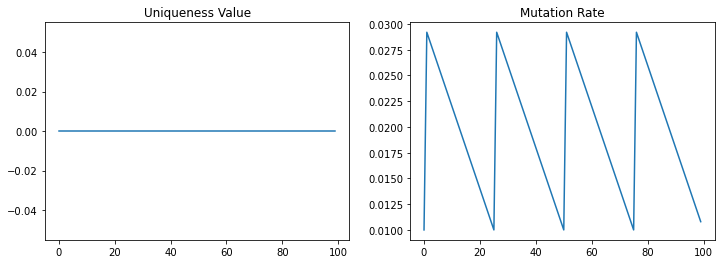

In [33]:
n_agents = 2000
agent_length=50
period = 10
Unique_max = 0.5
Mutation_max = 0.02
x = np.arange(0, n_epochs, 1)
#uniqueness_value = np.ones(shape=n_epochs) * Unique_max
uniqueness_value = np.zeros(shape=mutation_values.shape)
#mutation_values = signal.square(2 * np.pi * x / period, duty=0.5) * Mutation_max/2 + Mutation_max
#uniqueness_value = mutation_values * 50 + 0.5
#uniqueness_value = signal.square(2 * np.pi * x / 10, duty=0.5) * Unique_max/2 + Unique_max/2
#mutation_values = signal.square(2 * np.pi * x / period, duty=0.5) * Mutation_max/3 + Mutation_max
#uniqueness_value = signal.square(2 * np.pi * x / period, duty=0.5) * Unique_max/2 + 0.25
#mutation_values = signal.square(2 * np.pi * x / period, duty=0.5) * Mutation_max/2 + Mutation_max

fig, ax = plt.subplots(1,2,figsize=(12,4))
ax[0].plot(x[0:100], uniqueness_value[0:100])
ax[0].set_title("Uniqueness Value")
ax[1].plot(x[0:100], mutation_values[0:100])
ax[1].set_title("Mutation Rate")

In [29]:
sim = Simulation(calc_fitness, mutate_agent)
testPop = Population(agent_length=agent_length, num_agents=n_agents, bounds=(0,1000), num_genes=1)
testPop.define_visualization_function(plot_agents)
unique_weights = []

In [47]:
completed = 0
startTime = time.time()
for i in range(n_epochs):
    maxEpochs = 200
    unique_weight = min((testPop.epoch - sim.best_agents[-1][2]), maxEpochs)
    unique_weight = Unique_max / (1 + np.e ** -((unique_weight - (maxEpochs/2))/(maxEpochs/10))) #sigmoid function
    unique_weights.append(unique_weight)
    
    nextGen, fitness, diversity = sim.next_generation(testPop, mutation_rate=mutation_values[i], value_diversity = unique_weight, show_fitness = True, show_diversity = True)
    testPop.next_generation(nextGen, fitness, diversity)

    #if completed%round(n_epochs/1000) == 0:
        #testPop.save_img(str(testPop.epoch).zfill(5))

    clear_output(wait=True)
    completed += 1
    if i%10 == 0:
        print(f'{i}/{n_epochs} completed:\t|{"="*round(40 * i/n_epochs)}|{"-" * round(40 * (n_epochs-i)/n_epochs)}|\t{round(((time.time() - startTime)/completed) * (n_epochs-completed), 1)}s remaining')

print('Completed!')

Completed!


Text(0.5, 1.0, 'Best Solution found vs epoch')

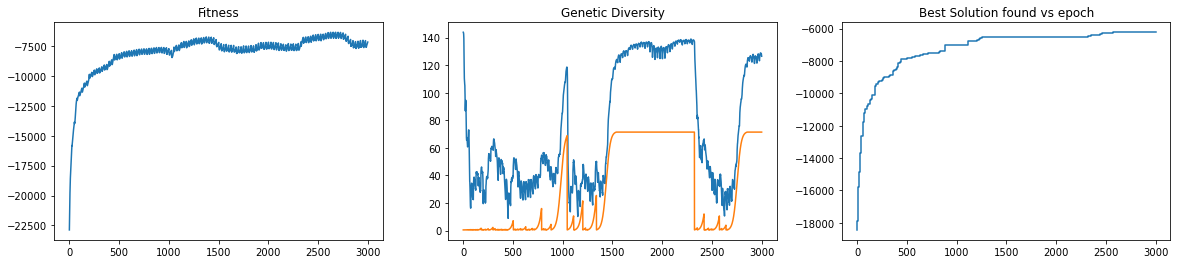

In [48]:
fig, ax = plt.subplots(1,3,figsize=(20,4))
ax[0].plot(np.arange(0, len(testPop.fitness_history)), testPop.fitness_history)
ax[0].set_title('Fitness')
ax[1].plot(np.arange(0, len(testPop.diversity_history)), testPop.diversity_history)
ax[1].plot(np.arange(0, len(unique_weights)), np.array(unique_weights) * max(testPop.diversity_history))
ax[1].set_title('Genetic Diversity')
#ax[2].step(np.array(sim.best_agents, dtype=object)[:,2], np.array(sim.best_agents, dtype=object)[:,1])
ax[2].step(np.append(np.array(sim.best_agents, dtype=object)[:,2], len(testPop.diversity_history)), np.append(np.array(sim.best_agents, dtype=object)[:,1], max(np.array(sim.best_agents, dtype=object)[:,1])))
ax[2].set_title('Best Solution found vs epoch')
#print(f'Final diversity score: {testPop.diversity_history[-1]}')

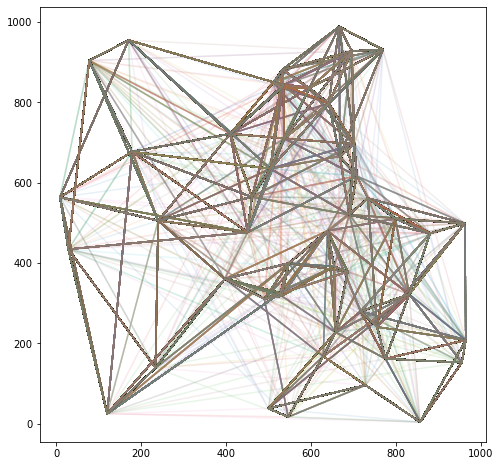

In [49]:
testPop.display()

 Best Fitness: -6228.361566033801


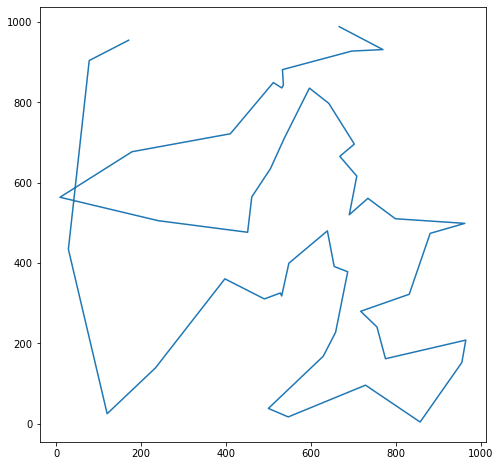

In [50]:
fig, ax = plt.subplots(1,1,figsize=(8,8))
ax.plot(testPop.points[:,0][sim.best_agents[-1][0]], testPop.points[:,1][sim.best_agents[-1][0]])
print(f' Best Fitness: {calc_fitness(sim.best_agents[-1][0], testPop.points)}')

Nearest Neighbor Pathfinding Fitness: -6079.142979273098


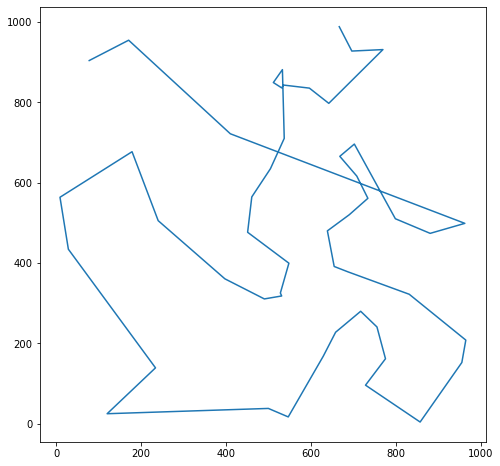

In [40]:
baseline = baseline_path(testPop.points)
fig, ax = plt.subplots(1,1,figsize=(8,8))
ax.plot(testPop.points[:,0][baseline], testPop.points[:,1][baseline])
print(f'Nearest Neighbor Pathfinding Fitness: {calc_fitness(baseline, testPop.points)}')
#ax.plot(testPop.points[:,0][sim.best_agents[1][0]], testPop.points[:,1][sim.best_agents[1][0]], alpha=0.5)

In [41]:
sim2 = Simulation(calc_fitness, mutate_agent)
testPop2 = Population(agent_length=agent_length, num_agents=n_agents, bounds=(0,1000), num_genes=1)
testPop2.define_visualization_function(plot_agents)
unique_weights2 = []

In [42]:
testPop2.agents = np.stack((baseline,) * n_agents)
testPop2.points = testPop.points
n_epochs = 1000

In [43]:
completed = 0
startTime = time.time()
for i in range(n_epochs):
    maxEpochs = 200
    unique_weight = min((i - sim2.best_agents[-1][2]), maxEpochs)
    unique_weight = Unique_max / (1 + np.e ** -((unique_weight - (maxEpochs/2))/(maxEpochs/10))) #sigmoid function
    unique_weights2.append(unique_weight)
    
    nextGen, fitness, diversity = sim2.next_generation(testPop2, mutation_rate=mutation_values[i], value_diversity = unique_weight, show_fitness = True, show_diversity = True)
    testPop2.next_generation(nextGen, fitness, diversity)

    #if completed%round(n_epochs/1000) == 0:
        #testPop.save_img(str(testPop.epoch).zfill(5))

    clear_output(wait=True)
    completed += 1
    if i%10 == 0:
        print(f'{i}/{n_epochs} completed:\t|{"="*round(40 * i/n_epochs)}|{"-" * round(40 * (n_epochs-i)/n_epochs)}|\t{round(((time.time() - startTime)/completed) * (n_epochs-completed), 1)}s remaining')

print('Completed!')

Completed!


Text(0.5, 1.0, 'Best Solution found vs epoch')

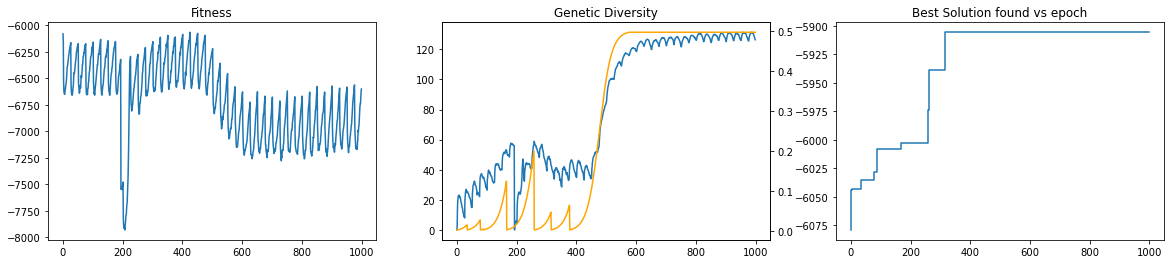

In [44]:
fig, ax = plt.subplots(1,3,figsize=(20,4))
ax[0].plot(np.arange(0, len(testPop2.fitness_history)), testPop2.fitness_history)
ax[0].set_title('Fitness')
ax[1].plot(np.arange(0, len(testPop2.diversity_history)), testPop2.diversity_history)
ax[1].twinx().plot(np.arange(0, len(unique_weights2)), np.array(unique_weights2), color='orange')
ax[1].set_title('Genetic Diversity')
#ax[2].step(np.array(sim.best_agents, dtype=object)[:,2], np.array(sim.best_agents, dtype=object)[:,1])
ax[2].step(np.append(np.array(sim2.best_agents, dtype=object)[:,2], len(testPop2.diversity_history)), np.append(np.array(sim2.best_agents, dtype=object)[:,1], max(np.array(sim2.best_agents, dtype=object)[:,1])))
ax[2].set_title('Best Solution found vs epoch')
#print(f'Final diversity score: {testPop.diversity_history[-1]}')

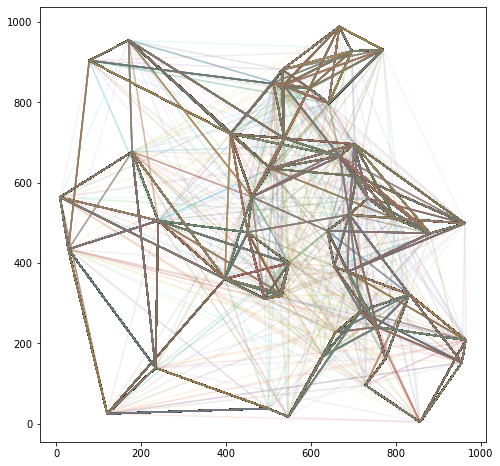

In [45]:
testPop2.display()

 Best Fitness: -5905.478062370774


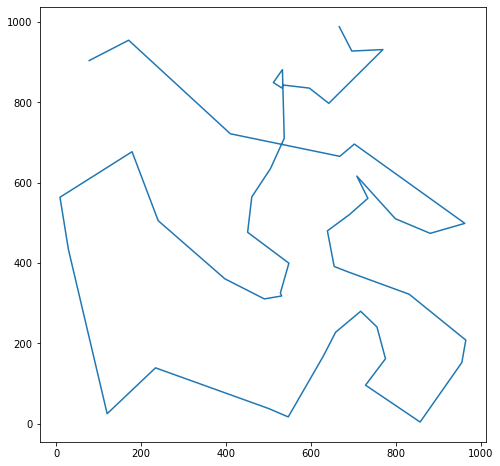

In [46]:
fig, ax = plt.subplots(1,1,figsize=(8,8))
ax.plot(testPop2.points[:,0][sim2.best_agents[-1][0]], testPop2.points[:,1][sim2.best_agents[-1][0]])
print(f' Best Fitness: {calc_fitness(sim2.best_agents[-1][0], testPop.points)}')